# Brain Tumor Detector

## Get and Load Dataset

In [1]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


In [2]:
!gdown --id 1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj
From (redirected): https://drive.google.com/uc?id=1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj&confirm=t&uuid=6573555c-ae5c-433c-bda3-e2f4b54d2321
To: /content/brain_tumor.zip
100% 156M/156M [00:02<00:00, 55.7MB/s]


In [3]:
!unzip -q brain_tumor.zip

In [4]:
ls -l

total 152156
-rw-r--r-- 1 root root 155791278 Jun 23 13:28 brain_tumor.zip
drwxr-xr-x 1 root root      4096 Jun 21 21:47 sample_data/
drwxr-xr-x 6 root root      4096 Jun 23 13:28 Testing/
drwxr-xr-x 6 root root      4096 Jun 23 13:28 Training/


In [5]:
!sudo apt-get install tree #just to see folder structures, run only on linux systems like colab

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 13 not upgraded.
Need to get 43.0 kB of archives.
After this operation, 115 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tree amd64 1.8.0-1 [43.0 kB]
Fetched 43.0 kB in 1s (84.9 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tree.
(Reading database ... 123069 files and directories currently install

In [6]:
!tree --dirsfirst --filelimit 4 ./Training/ #just to see folder structures, run only on linux systems like colab

./Training/
├── glioma [1321 entries exceeds filelimit, not opening dir]
├── meningioma [1339 entries exceeds filelimit, not opening dir]
├── notumor [1595 entries exceeds filelimit, not opening dir]
└── pituitary [1457 entries exceeds filelimit, not opening dir]

4 directories, 0 files


In [7]:
!tree --dirsfirst --filelimit 4 ./Testing/ #just to see folder structures, run only on linux systems like colab

./Testing/
├── glioma [300 entries exceeds filelimit, not opening dir]
├── meningioma [306 entries exceeds filelimit, not opening dir]
├── notumor [405 entries exceeds filelimit, not opening dir]
└── pituitary [300 entries exceeds filelimit, not opening dir]

4 directories, 0 files


## Load Dependencies

In [8]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix,\
                            classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

print('TF Version:', tf.__version__)

TF Version: 2.12.0


## Utility functions to create dataset generators

In [9]:
IMG_DIMS = (128, 128)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# call this function before running any model to get data into train and validation splits
# data is loaded as a TF dataset in a memory efficient format
def prepare_train_and_val_datasets():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",
        validation_split=0.2,
        subset="training",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",
        validation_split=0.2,
        subset="validation",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    train_ds = train_ds.prefetch(buffer_size=25)
    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds, val_ds

# call this function on any trained model to get prediction labels on the test data
# this loads the test dataset from the test directory as a test dataset
# iterates through the above dataset and returns the true labels as well as the predicted labels
def eval_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Testing",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100),
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    test_labels = np.array(test_labels)


    return test_labels, predictions


In [10]:
IMG_SHAPE

(128, 128, 3)

In [11]:
train_ds, val_ds = prepare_train_and_val_datasets()


Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


In [12]:
num_classes = 4

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=IMG_SHAPE),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        1

In [15]:
epochs=10
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, monitor="val_loss",restore_best_weights=True)
early_stopping_cb
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,callbacks=[early_stopping_cb]
)

Epoch 1/10
143/143 [==============================] - 19s 46ms/step - loss: 0.6606 - sparse_categorical_accuracy: 0.7309 - val_loss: 0.4324 - val_sparse_categorical_accuracy: 0.8310
Epoch 2/10
143/143 [==============================] - 7s 50ms/step - loss: 0.3333 - sparse_categorical_accuracy: 0.8731 - val_loss: 0.3147 - val_sparse_categorical_accuracy: 0.8792
Epoch 3/10
143/143 [==============================] - 6s 40ms/step - loss: 0.2199 - sparse_categorical_accuracy: 0.9182 - val_loss: 0.2419 - val_sparse_categorical_accuracy: 0.9273
Epoch 4/10
143/143 [==============================] - 7s 46ms/step - loss: 0.1342 - sparse_categorical_accuracy: 0.9475 - val_loss: 0.2794 - val_sparse_categorical_accuracy: 0.9177
Epoch 5/10
143/143 [==============================] - 7s 45ms/step - loss: 0.0975 - sparse_categorical_accuracy: 0.9652 - val_loss: 0.2414 - val_sparse_categorical_accuracy: 0.9343
Epoch 6/10
143/143 [==============================] - 6s 39ms/step - loss: 0.0707 - sparse_cat

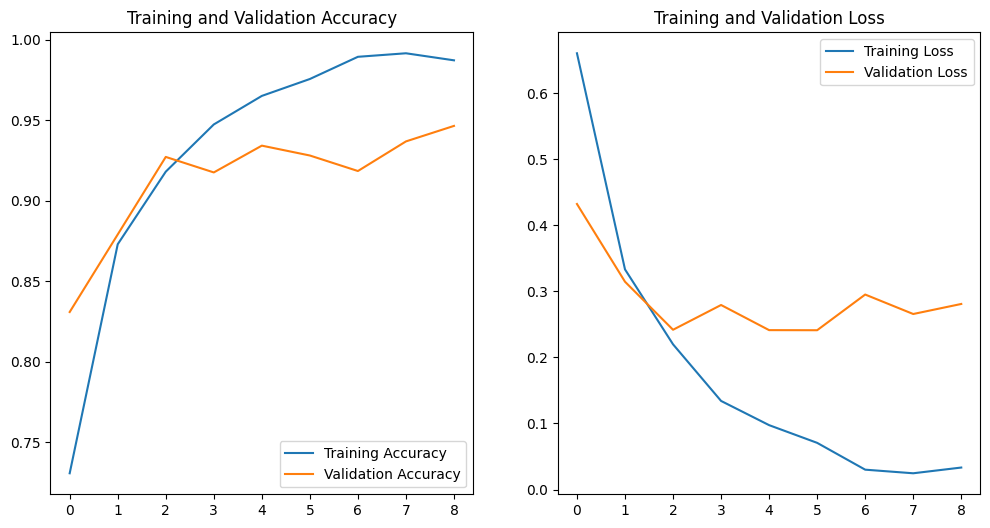

In [17]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(history.epoch[-1]+1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
test_labels, predictions=eval_model_on_test(model)
pred_index=np.argmax(predictions, axis=1)
print(confusion_matrix(test_labels, pred_index, labels=[0,1,2,3]))
print(classification_report(test_labels, pred_index ,labels=[0,1,2,3]))

Found 1311 files belonging to 4 classes.


Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:01<00:11,  1.14s/it]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:01<00:05,  1.79it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:01<00:03,  2.66it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:01<00:01,  3.65it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:01<00:01,  4.60it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:01<00:00,  5.48it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:01<00:00,  6.20it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:02<00:00,  6.59it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:02<00:00,  7.17it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:02<00:00,  7.71it/s]

1/1 [==============================] - 0s 262ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:02<00:00,  4.25it/s]

[[284  15   1   0]
 [ 37 235  31   3]
 [  2   1 402   0]
 [  4   4   2 290]]
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       300
           1       0.92      0.77      0.84       306
           2       0.92      0.99      0.96       405
           3       0.99      0.97      0.98       300

    accuracy                           0.92      1311
   macro avg       0.93      0.92      0.92      1311
weighted avg       0.93      0.92      0.92      1311



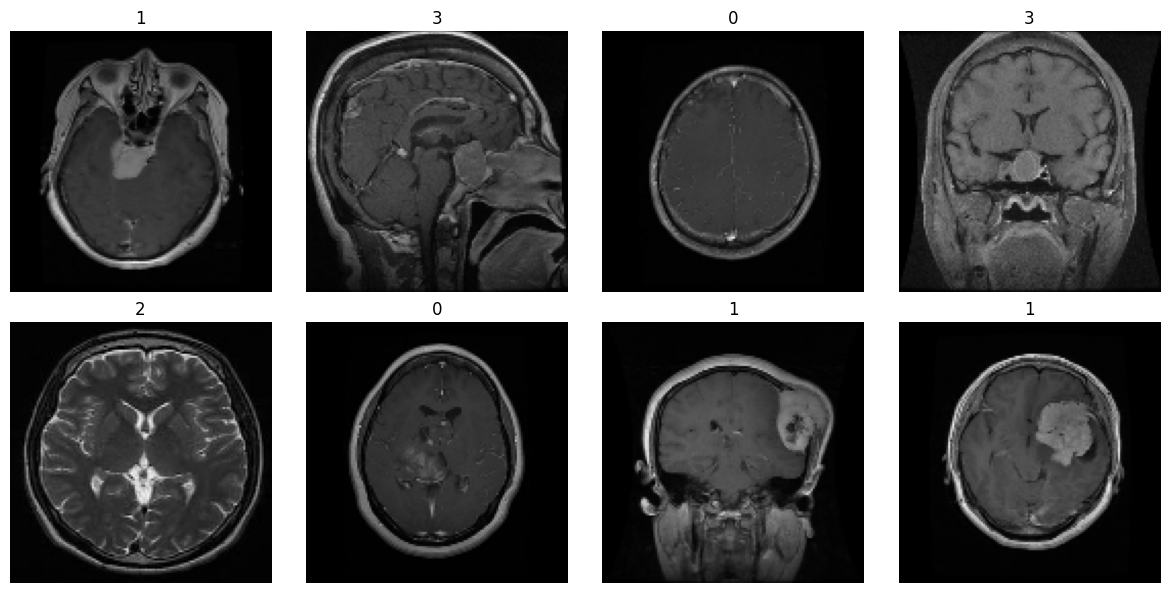

In [19]:
plt.figure(figsize=(12, 6))

for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.tight_layout()

## If you want to apply data augmentation operations on the train dataset

Go to the `prepare_train_and_val_datasets(...)` and you can add augmentation operations directly to the train dataset as follows:

```
train_ds = (train_ds.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                    .map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=1.5), label))
                        .shuffle(2000)
                        .prefetch(buffer_size=tf.data.AUTOTUNE))
```


Remember to check [`tf.image`](https://www.tensorflow.org/api_docs/python/tf/image#image_adjustments) for various image transforms available and you can play around with augmentations

__Be careful here and don't add too many transforms which can distort the images beyond recognition__

In [20]:
train_ds_aug = (train_ds.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                    .map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=1.5), label))




                        .shuffle(2000)
                        .prefetch(buffer_size=tf.data.AUTOTUNE))

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy'])
epochs=10
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,monitor="val_loss", restore_best_weights=True)
early_stopping_cb
history = model.fit(
  train_ds_aug,
  validation_data=val_ds,
  epochs=epochs,callbacks=[early_stopping_cb]
)

Epoch 1/10
143/143 [==============================] - 11s 21ms/step - loss: 0.2696 - sparse_categorical_accuracy: 0.9160 - val_loss: 0.2660 - val_sparse_categorical_accuracy: 0.9229
Epoch 2/10
143/143 [==============================] - 9s 30ms/step - loss: 0.1477 - sparse_categorical_accuracy: 0.9495 - val_loss: 0.2367 - val_sparse_categorical_accuracy: 0.9326
Epoch 3/10
143/143 [==============================] - 7s 20ms/step - loss: 0.1171 - sparse_categorical_accuracy: 0.9637 - val_loss: 0.2187 - val_sparse_categorical_accuracy: 0.9378
Epoch 4/10
143/143 [==============================] - 8s 18ms/step - loss: 0.1131 - sparse_categorical_accuracy: 0.9602 - val_loss: 0.2227 - val_sparse_categorical_accuracy: 0.9413
Epoch 5/10
143/143 [==============================] - 8s 23ms/step - loss: 0.0565 - sparse_categorical_accuracy: 0.9821 - val_loss: 0.2921 - val_sparse_categorical_accuracy: 0.9387
Epoch 6/10
143/143 [==============================] - 7s 20ms/step - loss: 0.0752 - sparse_cat

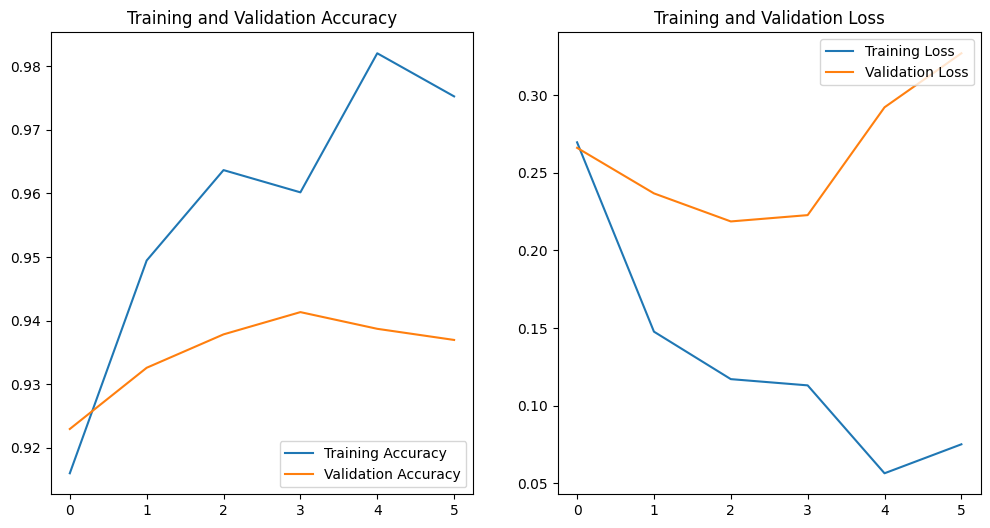

In [23]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(history.epoch[-1]+1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
test_labels, predictions=eval_model_on_test(model)
pred_index=np.argmax(predictions, axis=1)
print(confusion_matrix(test_labels, pred_index, labels=[0,1,2,3]))
print(classification_report(test_labels, pred_index ,labels=[0,1,2,3]))

Found 1311 files belonging to 4 classes.


Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:01<00:17,  1.76s/it]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:01<00:07,  1.22it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:02<00:04,  2.00it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:02<00:02,  2.86it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:02<00:01,  3.79it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:02<00:01,  4.70it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:02<00:00,  5.44it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:02<00:00,  5.83it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:02<00:00,  5.86it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:02<00:00,  6.53it/s]

1/1 [==============================] - 0s 79ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:05<00:00,  2.15it/s]

[[274  22   3   1]
 [ 12 258  32   4]
 [  0   2 403   0]
 [  1   2   8 289]]
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       300
           1       0.91      0.84      0.87       306
           2       0.90      1.00      0.95       405
           3       0.98      0.96      0.97       300

    accuracy                           0.93      1311
   macro avg       0.94      0.93      0.93      1311
weighted avg       0.93      0.93      0.93      1311



In [25]:
from tensorflow.keras.applications import EfficientNetB0
base_model = tf.keras.applications.EfficientNetB0(input_shape=IMG_SHAPE,
                                            include_top=False,
                                            weights='imagenet')


16705208/16705208 [==============================] - 0s 0us/step


In [26]:
image_batch, label_batch = next(iter(train_ds_aug))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 4, 4, 1280)


In [27]:
base_model.trainable = False
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 128, 128, 3)  7           ['rescaling_1[0][0]']            
                                                                                                  
 rescaling_2 (Rescaling)        (None, 128, 128, 3)  0           ['normalization[0][0

In [28]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = tf.keras.applications.efficientnet.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
#x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)
model_efficientNetB0 = tf.keras.Model(inputs, outputs)

In [30]:
base_learning_rate = 0.0001
model_efficientNetB0.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy'])
model_efficientNetB0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 4, 4, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                             

In [31]:
model_efficientNetB0.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy'])
epochs=15
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,monitor="val_loss", restore_best_weights=True)
early_stopping_cb
history = model_efficientNetB0.fit(
  train_ds_aug,
  validation_data=val_ds,
  epochs=epochs,callbacks=[early_stopping_cb]
)

Epoch 1/15
143/143 [==============================] - 27s 61ms/step - loss: 0.5410 - sparse_categorical_accuracy: 0.7943 - val_loss: 0.4121 - val_sparse_categorical_accuracy: 0.8476
Epoch 2/15
143/143 [==============================] - 10s 39ms/step - loss: 0.3455 - sparse_categorical_accuracy: 0.8724 - val_loss: 0.3626 - val_sparse_categorical_accuracy: 0.8695
Epoch 3/15
143/143 [==============================] - 10s 33ms/step - loss: 0.3037 - sparse_categorical_accuracy: 0.8860 - val_loss: 0.3962 - val_sparse_categorical_accuracy: 0.8695
Epoch 4/15
143/143 [==============================] - 12s 42ms/step - loss: 0.2533 - sparse_categorical_accuracy: 0.9090 - val_loss: 0.3306 - val_sparse_categorical_accuracy: 0.8844
Epoch 5/15
143/143 [==============================] - 10s 33ms/step - loss: 0.2428 - sparse_categorical_accuracy: 0.9068 - val_loss: 0.3203 - val_sparse_categorical_accuracy: 0.8949
Epoch 6/15
143/143 [==============================] - 10s 37ms/step - loss: 0.2291 - spars

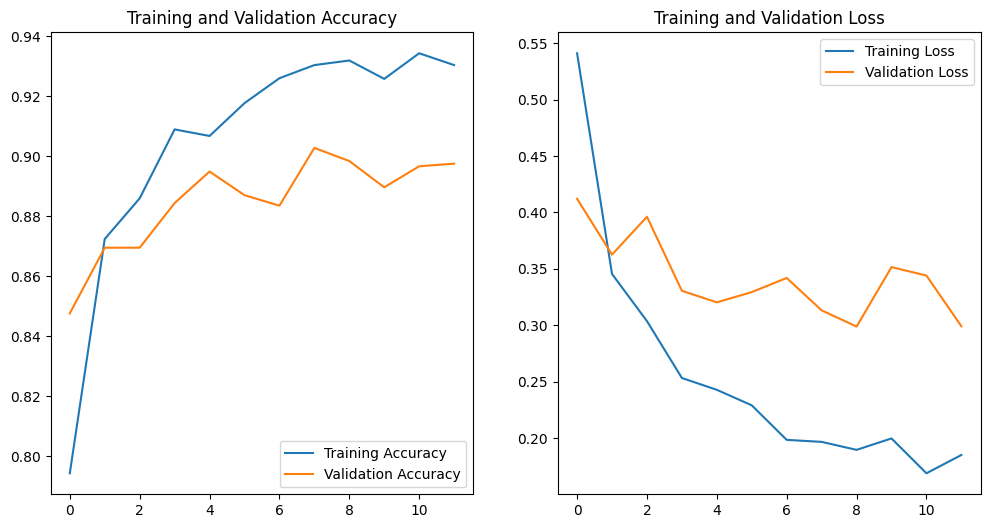

In [32]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(history.epoch[-1]+1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
test_labels, predictions=eval_model_on_test(model_efficientNetB0)
pred_index=np.argmax(predictions, axis=1)
print(confusion_matrix(test_labels, pred_index, labels=[0,1,2,3]))
print(classification_report(test_labels, pred_index ,labels=[0,1,2,3]))

Found 1311 files belonging to 4 classes.


Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 2s 28ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:03<00:33,  3.38s/it]

4/4 [==============================] - 0s 28ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:03<00:13,  1.53s/it]

4/4 [==============================] - 0s 27ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:03<00:07,  1.07it/s]

4/4 [==============================] - 0s 26ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:04<00:04,  1.52it/s]

4/4 [==============================] - 0s 26ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:04<00:03,  1.99it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:04<00:01,  2.51it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:04<00:01,  3.04it/s]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:04<00:00,  3.35it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:05<00:00,  3.77it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:05<00:00,  4.17it/s]

1/1 [==============================] - 2s 2s/step


Predicting on Test Data: 100%|██████████| 11/11 [00:10<00:00,  1.07it/s]

[[233  57   2   8]
 [ 19 269  12   6]
 [  2   3 400   0]
 [  3  13   1 283]]
              precision    recall  f1-score   support

           0       0.91      0.78      0.84       300
           1       0.79      0.88      0.83       306
           2       0.96      0.99      0.98       405
           3       0.95      0.94      0.95       300

    accuracy                           0.90      1311
   macro avg       0.90      0.90      0.90      1311
weighted avg       0.91      0.90      0.90      1311



In [34]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  238


In [35]:
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False
  if('bn' in layer.name):
    layer.trainable = False

In [36]:
model_efficientNetB0.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate/10),
              metrics=['sparse_categorical_accuracy'])

model_efficientNetB0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 4, 4, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                             

In [37]:
fine_tune_epochs = 10
total_epochs =  15 + fine_tune_epochs

history_fine = model_efficientNetB0.fit(train_ds_aug,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds,callbacks=[early_stopping_cb])

Epoch 12/25
143/143 [==============================] - 46s 87ms/step - loss: 1.0719 - sparse_categorical_accuracy: 0.6659 - val_loss: 0.5038 - val_sparse_categorical_accuracy: 0.7925
Epoch 13/25
143/143 [==============================] - 17s 79ms/step - loss: 0.2860 - sparse_categorical_accuracy: 0.8974 - val_loss: 0.3278 - val_sparse_categorical_accuracy: 0.8897
Epoch 14/25
143/143 [==============================] - 17s 84ms/step - loss: 0.1862 - sparse_categorical_accuracy: 0.9359 - val_loss: 0.1211 - val_sparse_categorical_accuracy: 0.9562
Epoch 15/25
143/143 [==============================] - 16s 77ms/step - loss: 0.1156 - sparse_categorical_accuracy: 0.9586 - val_loss: 0.1283 - val_sparse_categorical_accuracy: 0.9597
Epoch 16/25
143/143 [==============================] - 18s 77ms/step - loss: 0.0857 - sparse_categorical_accuracy: 0.9729 - val_loss: 0.2739 - val_sparse_categorical_accuracy: 0.9159
Epoch 17/25
143/143 [==============================] - 16s 76ms/step - loss: 0.0886 -

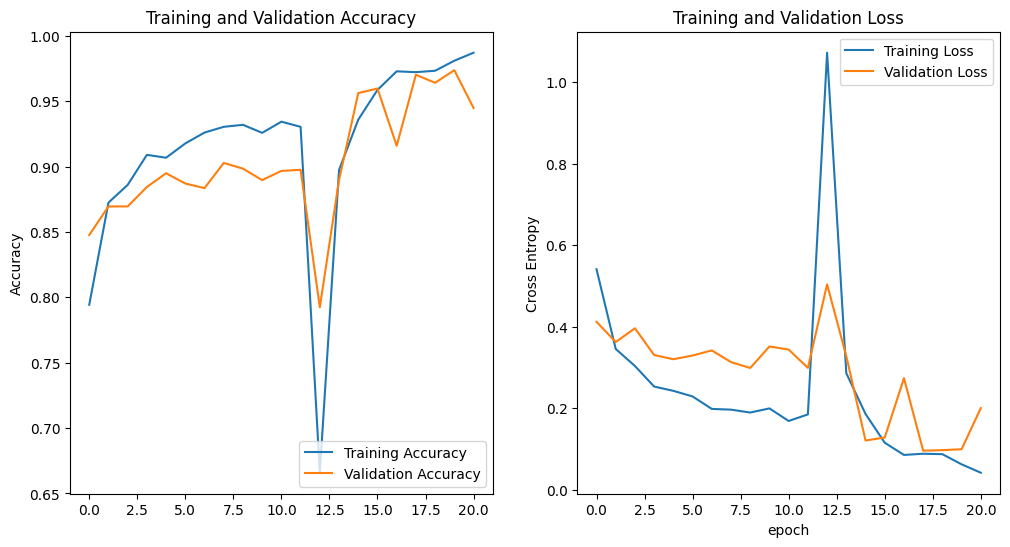

In [39]:
acc += history_fine.history['sparse_categorical_accuracy']
val_acc += history_fine.history['val_sparse_categorical_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [40]:
test_labels, predictions=eval_model_on_test(model_efficientNetB0)
pred_index=np.argmax(predictions, axis=1)
print(confusion_matrix(test_labels, pred_index, labels=[0,1,2,3]))
print(classification_report(test_labels, pred_index ,labels=[0,1,2,3]))

Found 1311 files belonging to 4 classes.


Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 2s 34ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:03<00:30,  3.09s/it]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:03<00:13,  1.55s/it]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:03<00:07,  1.02it/s]

4/4 [==============================] - 0s 27ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:04<00:04,  1.41it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:04<00:03,  1.84it/s]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:04<00:02,  2.33it/s]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:04<00:01,  2.81it/s]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:05<00:00,  3.23it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:05<00:00,  3.50it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:05<00:00,  3.92it/s]

1/1 [==============================] - 1s 1s/step


Predicting on Test Data: 100%|██████████| 11/11 [00:10<00:00,  1.07it/s]

[[288  11   0   1]
 [  5 297   3   1]
 [  5   3 397   0]
 [  1   4   0 295]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       300
           1       0.94      0.97      0.96       306
           2       0.99      0.98      0.99       405
           3       0.99      0.98      0.99       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311

